<a href="https://colab.research.google.com/github/Paushi2003/Building_Footprint_Extraction/blob/main/Image_Segmentation_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geopandas gradio shapely scikit-image

In [ ]:
import os
import cv2
from PIL import Image
import numpy as np
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda
from keras import backend as K
from matplotlib import pyplot as plt
from tensorflow.keras.utils import to_categorical
import geopandas as gpd
import matplotlib.pyplot as plt
from google.colab import drive
from keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab.patches import cv2_imshow
import geopandas as gpd
from skimage.measure import regionprops, label
from shapely.geometry import Polygon
import shutil

In [ ]:
drive.mount('/content/drive')
data_dir = 'drive/MyDrive/Building_footprint_dataset'

Mounted at /content/drive


In [ ]:
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (256, 256))
    img = img.astype(np.float32) / 255.0
    return img

def preprocess_mask(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (256, 256))
    mask = (mask > 0).astype(np.float32)
    return mask

images = []
masks = []
images_path = os.path.join('drive/MyDrive/Building_footprint_dataset/png/train')
masks_path = os.path.join('drive/MyDrive/Building_footprint_dataset/png/train_labels')

for filename in os.listdir(images_path):
    image_path = os.path.join(images_path, filename)
    mask_path = os.path.join(masks_path, filename)
    images.append(preprocess_image(image_path))
    masks.append(preprocess_mask(mask_path))

In [ ]:
X_train = np.array(images)
y_train = np.array(masks)
y_train = to_categorical(y_train, num_classes=2)

In [ ]:
def multi_unet_model(n_classes=2, image_height=256, image_width=256, image_channels=3):

  inputs = Input((image_height, image_width, image_channels))

  source_input = inputs

  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.2)(c1)
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  outputs = Conv2D(n_classes, (1,1), activation="sigmoid")(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model

In [ ]:
model = multi_unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy',metrics='accuracy')
model.fit(X_train, y_train, epochs=50, batch_size=5)
model.save('drive/My Drive/building_footprint_extraction_model.h5')
model.save('drive/My Drive/building_footprint_extraction_model.keras')

In [ ]:
model = load_model('drive/My Drive/building_footprint_extraction_model.h5')
model.summary()

1/1 [==============================] - 0s 155ms/step


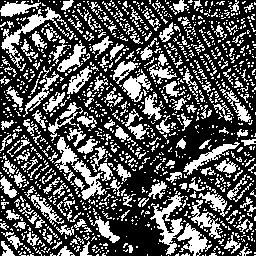

True

In [ ]:
img = load_img('/content/22828930_15.png', target_size=(256, 256))
img_array = img_to_array(img)
img_array = img_array.reshape((1, 256, 256, 3))
img_array = img_array / 255.0
predictions = model.predict(img_array)
predicted_image = np.argmax(predictions, axis=3)
predicted_image = predicted_image[0,:,:]
predicted_image = predicted_image * 255
cv2_imshow(predicted_image)
cv2.imwrite('output.jpg',predicted_image)

In [ ]:
threshold = 0.5
binary_mask = (predictions > threshold).astype(np.uint8)[:, :, 1]
if np.sum(binary_mask) == 0:
    print("No building pixels detected. Saving an empty shapefile.")
else:
    labeled_mask = label(binary_mask)
    building_polygons = []
    props = regionprops(labeled_mask)
    for prop in props:
        polygon = Polygon([(point[1], point[0]) for point in prop.coords])
        building_polygons.append(polygon)
    gdf = gpd.GeoDataFrame(geometry=building_polygons, crs="EPSG:4326")
    output_shapefile = "shapefiles/building_footprints.shp"
    if os.path.exists('shapefiles'):
      pass
    else:
      os.mkdir('shapefiles')
    gdf.to_file(output_shapefile)
    shutil.make_archive('shapefile', 'zip', 'shapefiles')

In [ ]:
shapefile_path = "/content/building_footprints.shp"
gdf = gpd.read_file(shapefile_path)
gdf.plot()
plt.title("Building Footprints")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()